<a href="https://colab.research.google.com/github/MontgomeryRobotics/cv-ml-cloud/blob/main/Apparel_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Apparel Classification**

---

Sorting and classifying different clothing articles efficiently and quickly can be handy to the fashion, retail and logistics industries. They can use the power of Computer vision to swiftly and accurately catalogue their products, provide better offerings to their customers and also cut down the need for manual labour to make it possible to assign the available staff to other vital roles.

Let's see how we can solve an apparel classification problem with the help of Computer Vision and Machine Learning.

## Dataset Preparation

We will be using a generalized version of the <a href="https://www.kaggle.com/trolukovich/apparel-images-dataset" target="_blank">Apparel images dataset</a> available on Kaggle. The dataset contains 11385 apparel images for multi-label/class classification.

The classes include:
1. Dress: 2570 Images
2. Pants: 2789 Images
3. Shirt: 1686 images
4. Shoes: 3418 images
5. Shorts: 922 Images

The dataset is further divided into train, validation and test data having split ratio of 0.7, 0.2 and 0.1 respectively.

Directory structure:
```
Dataset
├── train
│   ├── class1
|   |   ├── img1
|   |   └── ...
│   ├── class2
│   └── ...
├── val
│   └── ...
└── test
    └── ...
```

<a href="https://www.dropbox.com/s/toahdh2cw0jaj42/Dataset-20210923T081130Z-001.zip?dl=1" target="_blank">Dataset Link</a>

### Download Dataset

In [2]:
# Download the dataset
!wget -O dataset.zip "https://www.dropbox.com/s/toahdh2cw0jaj42/Dataset-20210923T081130Z-001.zip?dl=1"

# Extract the dataset
!unzip -q -u dataset.zip

--2025-08-31 00:50:05--  https://www.dropbox.com/s/toahdh2cw0jaj42/Dataset-20210923T081130Z-001.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/zgsgks95jdaskk9s1sqfx/Dataset-20210923T081130Z-001.zip?rlkey=chpmae971lvh4fjck8j7xo6gz&dl=1 [following]
--2025-08-31 00:50:05--  https://www.dropbox.com/scl/fi/zgsgks95jdaskk9s1sqfx/Dataset-20210923T081130Z-001.zip?rlkey=chpmae971lvh4fjck8j7xo6gz&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucec8b59954bbbee6c0617227072.dl.dropboxusercontent.com/cd/0/inline/Cwf_SFpQCbAmX95sBOaoR9NYPusyubNlhBnpDMZsiOMs9OvpUD614efZbYgpt4H2icb3W31r7v3_s4bRNO08ri94bQcmV3dHmfin3LYiWEYEmHIYjDkz_JRCReu_67loNZKdywNW0dTvbcHNXzahcO6B/file?dl=1# [following]
--2025-08-31 00:50

## Import Libraries

Let us import all the required libraries

In [3]:
# Importing Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Softmax, Dense,Dropout,BatchNormalization,Flatten
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from PIL import Image

## Loading Data

In Keras, **Image Data Generator** provides real-time data augmentation. It generates augmented images on the fly while the model is still training, ensuring that the model receives new variations of the images at each epoch.

We have used the images, leaving all other parameters as default. One may use different augmentation techniques by changing the values of the various parameters accordingly.

In [4]:
# Defining Data Generator
gen = ImageDataGenerator()

**Batch Size** refers to number of images in a batch. Loading the images in batches helps us save memory. Here will have batch size of 16, which means there will be 16 images in a batch.

**Seed** is used for random shuffling and transformations.

In [5]:
# Defining  Batch Size and seed
BATCH_SIZE = 16
SEED = 21

We will now generate the dataset. The input image size is set to 224x224 pixels. The class mode is "categorical" as we have 5 different classes of images.

In [6]:
# Acquring Training images from the directory using flow_from_directory() method.
train_datagen = gen.flow_from_directory(directory = '/content/Dataset/train',
                                        target_size = (224, 224),
                                        color_mode = "rgb",
                                        classes = None,
                                        class_mode = "categorical",
                                        batch_size = BATCH_SIZE,
                                        shuffle = True,
                                        seed = SEED,
                                        interpolation = "nearest")

Found 7967 images belonging to 5 classes.


In [7]:
# Acquring Validation images from the directory using flow_from_directory() method.
val_datagen = gen.flow_from_directory(directory = '/content/Dataset/val',
                                      target_size = (224, 224),
                                      color_mode = "rgb",
                                      classes = None,
                                      class_mode = "categorical",
                                      batch_size = BATCH_SIZE,
                                      shuffle = True,
                                      seed = SEED,
                                      interpolation = "nearest")

Found 2275 images belonging to 5 classes.


In [8]:
# Acquring Testing images from the directory using flow_from_directory() method.
test_datagen = gen.flow_from_directory(directory = '/content/Dataset/test',
                                       target_size = (224, 224),
                                       color_mode = "rgb",
                                       classes = None,
                                       class_mode = "categorical",
                                       batch_size = 1,
                                       shuffle = False, # Here Shuffle is set to False, so that we can test our model.
                                       seed = SEED,
                                       interpolation = "nearest")

Found 1143 images belonging to 5 classes.


Defining class names in a list to help with printing

In [9]:
# Classes of images in train dataset
classes = ['Dress', 'Pants', 'Shirt', 'Shoes', 'Shorts']

Let us now take a peek at a few images from the training set.

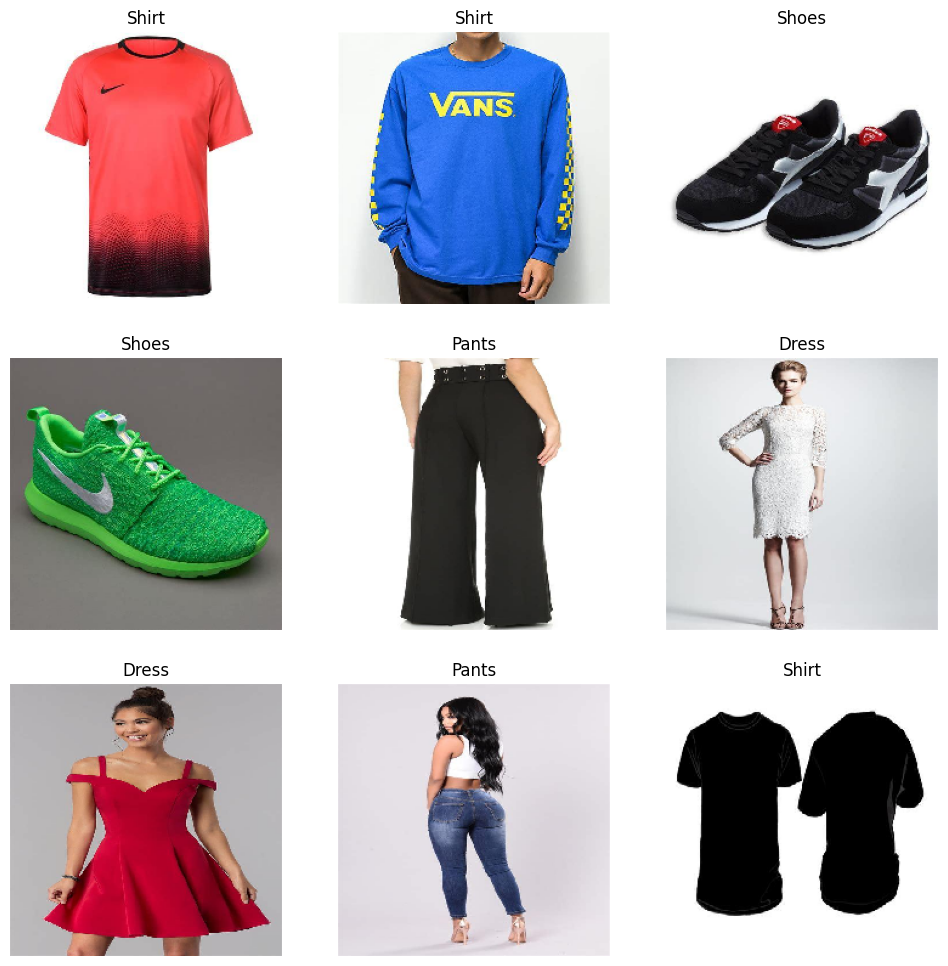

In [10]:
# Preparing the Samples and Plot for displaying output

# Create figure
fig = plt.figure(figsize = (12, 12))
for i in range(9):
  plt.subplot(330 + 1 + i)
  img, label = next(train_datagen)

  label = label[0].astype('uint8')
  label = np.squeeze(label)
  label = np.argmax(label, axis = 0)

  plt.axis('off')
  plt.imshow(img[0].astype(np.uint8))
  plt.title(classes[label])

# Displaying the figure
plt.show()

## **Initialize Pre-trained Model**

For this task, we will be using the **EfficientNet-B7** classification model.
EfficientNets are state-of-the-art image classification models and significantly outperform other ConvNets.

EfficientNet-B7 achieves 84.4% top-1 accuracy on ImageNet Dataset but being 8.4x smaller and 6.1x faster than GPipe.

Let us now import the EfficientNet B7 model pre-trained on Imagenet Dataset. Here we have set the input image size to be 224x224 pixels and kept the pooling layer to be GlobalMaxPooling2D

In [11]:
# Importing EfficientNet B7 Model
image_model = tf.keras.applications.EfficientNetB7(include_top = False,
                                                   weights = 'imagenet',
                                                   input_shape = (224, 224, 3),
                                                   pooling = 'max')

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


We can see the model layers and output shapes using the model summary.

In [12]:
# Printing Model Summary
print(image_model.summary())

Model: "efficientnetb7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,728 │ stem_conv_pad[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        256 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        576 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        256 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 64)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 64)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 16)  │      1,040 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 64)  │      1,088 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 64)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      2,048 │ block1a_se_excit

 Total params: 64,097,687 (244.51 MB)

 Trainable params: 63,786,960 (243.33 MB)

 Non-trainable params: 310,727 (1.19 MB)

None


Now we add Dense layers to the pre-trained model. We will also add Dropout and BatchNormalization to reduce overfitting.

We will then compile the model with the optimizer of our choice and some other hyperparameters.

We have used Adam Optimizer with an initial learning rate of 0.0001, `categorical_crossentropy` as loss function and `accuracy` as the metric.

In [13]:
# Adding Dense, BatchNorm and Droupout layers to base model
# to have output for 5 Class Classification
x = Dense(1024, activation = 'relu')((image_model.output))
x = Dropout(0.5)(x)
x = Dense(512, activation = 'relu')(x)
x = Dense(64, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(16, activation='relu')(x)
predictions = Dense(5, activation = 'softmax')(x)

# Define the input and output layers of the model
model = Model(inputs = image_model.input, outputs = predictions)

# Compile model and define Optimizer
model.compile(optimizer = tf.keras.optimizers.Adam(0.0001),
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

Let us now see the the model summary of the compiled model.

In [14]:
# Printing Final Model Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,728 │ stem_conv_pad[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        256 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        576 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        256 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 64)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 64)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 16)  │      1,040 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 64)  │      1,088 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 64)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      2,048 │ block1a_se_excit

 Total params: 67,279,164 (256.65 MB)

 Trainable params: 66,968,309 (255.46 MB)

 Non-trainable params: 310,855 (1.19 MB)

## Callbacks

Callbacks allow you to adjust settings or save your model state during the training process.

We are using `ModelCheckpoint` Callback and the `ReduceLR` Callback.

**`ModelCheckpoint`** Callback saves model with best validation accuracy

In [15]:
# Assigning Checkpoint Path for Saved Model
filepath = '/content/Models/apparel-classification-EfNetB7_15Epochs.h5'

In [16]:
# Defining ModelCheckpoint Callback
model_save = tf.keras.callbacks.ModelCheckpoint(filepath,
                                                monitor = "val_accuracy",
                                                verbose = 0,
                                                save_best_only = True,
                                                save_weights_only = False,
                                                mode = "max",
                                                save_freq = "epoch")

**`ReduceLR`** reduces the learning rate by a factor (0.1), if validation loss remains same for 6 consecutive epochs.

In [17]:
# Defining Reduce lr callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                                 factor = 0.1,
                                                 patience = 6,
                                                 verbose = 1,
                                                 min_delta = 5*1e-3,
                                                 min_lr = 5*1e-9,)

In [18]:
# Saving callbacks in a list
callback = [model_save, reduce_lr]

## Model Training

We will now train the model using the `model.fit()` method for 15 epochs passing the training datagen, validation datagen, and the callbacks defined earlier.

In [ ]:
# Training the model
history = model.fit(train_datagen,
                    epochs = 15,
                    steps_per_epoch = (len(train_datagen)),
                    validation_data = val_datagen,
                    validation_steps = (len(val_datagen)),
                    shuffle = False,
                    callbacks = callback)

Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 730ms/step - accuracy: 0.5147 - loss: 1.2500

498/498 ━━━━━━━━━━━━━━━━━━━━ 704s 858ms/step - accuracy: 0.5151 - loss: 1.2491 - val_accuracy: 0.9714 - val_loss: 0.1659 - learning_rate: 1.0000e-04
Epoch 2/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.9505 - loss: 0.2456

498/498 ━━━━━━━━━━━━━━━━━━━━ 261s 523ms/step - accuracy: 0.9505 - loss: 0.2455 - val_accuracy: 0.9864 - val_loss: 0.0870 - learning_rate: 1.0000e-04
Epoch 3/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.9825 - loss: 0.1064

498/498 ━━━━━━━━━━━━━━━━━━━━ 270s 540ms/step - accuracy: 0.9825 - loss: 0.1063 - val_accuracy: 0.9886 - val_loss: 0.0640 - learning_rate: 1.0000e-04
Epoch 4/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 306s 508ms/step - accuracy: 0.9865 - loss: 0.0757 - val_accuracy: 0.9873 - val_loss: 0.0523 - learning_rate: 1.0000e-04
Epoch 5/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 263s 510ms/step - accuracy: 0.9890 - loss: 0.0567 - val_accuracy: 0.9811 - val_loss: 0.0838 - learning_rate: 1.0000e-04
Epoch 6/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 261s 509ms/step - accuracy: 0.9926 - loss: 0.0339 - val_accuracy: 0.9767 - val_loss: 0.0940 - learning_rate: 1.0000e-04
Epoch 7/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 266s 516ms/step - accuracy: 0.9943 - loss: 0.0271 - val_accuracy: 0.9886 - val_loss: 0.0539 - learning_rate: 1.0000e-04
Epoch 8/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 257s 508ms/step - accuracy: 0.9944 - loss: 0.0263 - val_accuracy: 0.9868 - val_loss: 0.0597 - learning_rate: 1.0000e-04
Epoch 9/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 253s 507ms/

498/498 ━━━━━━━━━━━━━━━━━━━━ 271s 544ms/step - accuracy: 0.9984 - loss: 0.0110 - val_accuracy: 0.9899 - val_loss: 0.0613 - learning_rate: 1.0000e-05
Epoch 13/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 254s 510ms/step - accuracy: 0.9983 - loss: 0.0107 - val_accuracy: 0.9890 - val_loss: 0.0610 - learning_rate: 1.0000e-05
Epoch 14/15
419/498 ━━━━━━━━━━━━━━━━━━━━ 37s 474ms/step - accuracy: 0.9992 - loss: 0.0069

## Loss and Accuracy Plot

Let us plot the loss and the accuracy graphs to visualize how the metrics changed throughout the model training.

In [ ]:
# Summarize history for loss
tr_losses = history.history['loss']
val_losses = history.history['val_loss']
tr_accs = history.history['accuracy']
val_accs = history.history['val_accuracy']
plt.plot(tr_losses, label = "train_loss")
plt.plot(val_losses, label = "val_loss")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Summarize history for accuracy
tr_accs = history.history['accuracy']
val_accs = history.history['val_accuracy']
plt.plot(tr_accs, label = "acc_train")
plt.plot(val_accs, label = "acc_val")
plt.ylim((0.3, 1.))
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()

## Model Evaluation

We will now test the trained model on the test set containing the images the model has not seen.

In [ ]:
# Prediction Function
predictions = model.predict(test_datagen, verbose = 1, steps = (len(test_datagen)))

In [ ]:
# Only save class with highest confidence for each image
predictions.squeeze().argmax(axis = 1)

### Classification Report

The classification report shows the main classification metrics.

In [ ]:
# Classification Report
print(classification_report(test_datagen.classes, predictions.squeeze().argmax(axis = 1)))

### Confusion Matrix

Finally, we will construct the confusion matrix for the predictions obtained on the test set.

In [ ]:
# Confusion Matrix
print('Confusion Matrix')
cm = confusion_matrix(test_datagen.classes, predictions.squeeze().argmax(axis = 1))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

disp = disp.plot(include_values = True,
                 values_format = 'd',
                 cmap = 'viridis',
                 ax = None,
                 xticks_rotation = 'horizontal')

plt.show()

## External Test Images

Let's try to visualize this results by testing our model on an image of each class .

In [ ]:
def test(path):

  # Load the image using keras
  img = tf.keras.preprocessing.image.load_img(path,
                                              grayscale = False,
                                              color_mode = 'rgb',
                                              target_size = (224, 224, 3),
                                              interpolation = 'nearest')

  # Display the image
  plt.imshow(img)
  plt.axis('off')

  # Convert image to array for feeding it to the model
  img_array = np.asarray(img)

  # Expand dimension of img array
  img_array = np.expand_dims(img_array, 0)

  # Take prediction
  predictions = model.predict(img_array)

  # Evaluate Score
  score = predictions[0]

  return print('This image is a {} with a {:.2f} % confidence.'.format(classes[np.argmax(score)], 100 * np.max(score)))

### Download test images

In [ ]:
# Download test images
!wget -O test-images.zip "https://www.dropbox.com/sh/2hpc50t687r0fdt/AADokyQsM-0kacFVl5KL-ONTa?dl=1"

# Extract images
!unzip -q -u test-images.zip

### Test Image 1

In [ ]:
# Testing Image
test('/content/test-image-1.jpg')

### Test Image 2

In [ ]:
# Testing Image
test('/content/test-image-2.jpg')

### Test Image 3

In [ ]:
# Testing Image
test('/content/test-image-3.jpg')

### Test Image 4

In [ ]:
# Testing Image
test('/content/test-image-4.jpg')

### Test Image 5

In [ ]:
# Testing Image
test('/content/test-image-5.jpg')

## Conclusion

We have successfully trained an image classifier for classifying five different types of apparels. A similar approach can be extended to develop a classifier with various clothing classes and similar classification problems.